In [1]:
import os
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import matplotlib.pyplot as plt

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
base_dir = "/root/workspace/DeepLearning/ConvNet/datasets/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [3]:
# prepare model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.7017 - acc: 0.5949 - val_loss: 0.4546 - val_acc: 0.8130
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.4796 - acc: 0.7830 - val_loss: 0.3657 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3642 - acc: 0.8338 - val_loss: 0.3360 - val_acc: 0.8560
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3327 - acc: 0.8577 - val_loss: 0.3027 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2850 - acc: 0.8881 - val_loss: 0.2825 - val_acc: 0.8970
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2707 - acc: 0.8872 - val_loss: 0.2713 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2545 - acc: 0.8947 - val_loss: 0.2643 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 0s 3ms/step - loss: 0.

In [7]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1.-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

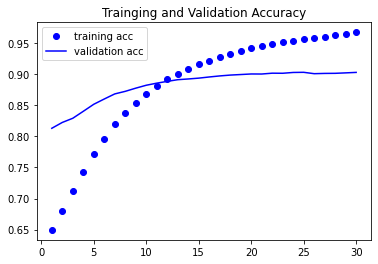

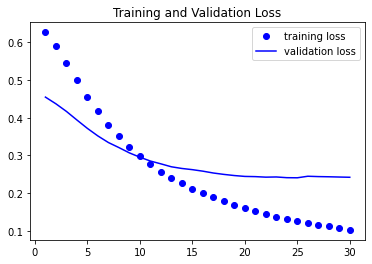

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='validation acc')
plt.title('Trainging and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# do not train conv_base
conv_base.trainable = False

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch=100, epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 14s 133ms/step - loss: 0.6848 - acc: 0.5957 - val_loss: 0.4516 - val_acc: 0.8340
Epoch 2/30
100/100 [==============================] - 13s 127ms/step - loss: 0.4998 - acc: 0.7590 - val_loss: 0.3744 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 13s 134ms/step - loss: 0.4311 - acc: 0.7971 - val_loss: 0.3337 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 13s 132ms/step - loss: 0.3827 - acc: 0.8266 - val_loss: 0.3059 - val_acc: 0.8910
Epoch 5/30
100/100 [==============================] - 13s 131ms/step - loss: 0.3451 - acc: 0.8483 - val_loss: 0.2929 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 13s 125ms/step - loss: 0.3401 - acc: 0.8572 - val_loss: 0.2876 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 12s 124ms/step - loss: 0.3277 - acc: 0.8582 - val_loss: 0.2743 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 1

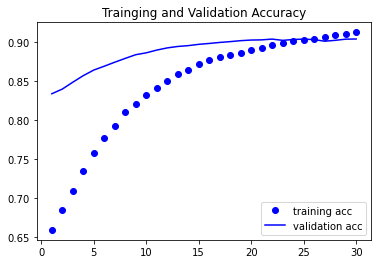

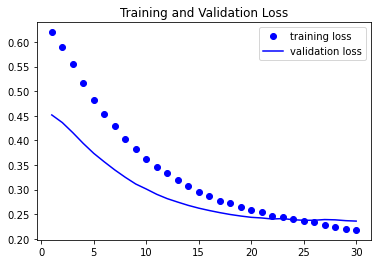

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='validation acc')
plt.title('Trainging and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [14]:
conv_base.trainable = True
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
model.summary()
history = model.fit(train_generator,
                    steps_per_epoch=100, epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 4,457,473
Non-trainable params: 12,354,880
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 13s 129ms/step - loss: 0.1898 - acc: 0.9329 -

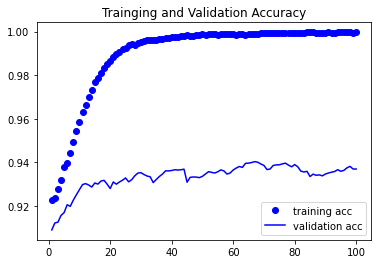

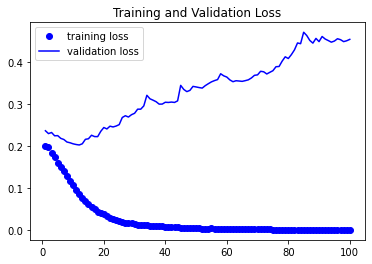

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='validation acc')
plt.title('Trainging and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), 
    batch_size=20, class_mode='binary'
)
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test_acc', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 51ms/step - loss: 0.4530 - acc: 0.9390
test_acc 0.9390000104904175
